# Demonstration and unit-testing `ri_ci` for Matlab

This file was tested on Matlab version 2019b, using the Jupyter `matlab_kernel`.

###  Matlab preliminaries

In [3]:
rng('default'); % set seed for replicability
addpath('../m'); % assumes we are in the /demo/ folder as pwd

In [2]:
%  Parameters of the simulation
N = 1000; % number of observations
R = 500 ; % number of alternative permutations of the treatment assignment to be used
tau = 1 ; % treatment effect

In [ ]:
%  Generate data 
x = randn(N,1);
y0 = x + randn(N,1);
y1 = y0 + tau;
t = (rand(N,1) >= 0.5 ) ; % treatment status
y = y0 + t.*(y1 - y0) ; % switching regression
T0 = (rand(N,R) >= 0.5) ; % set of potential randomizations
DATA = array2table([y,t,x] , 'VariableNames',{'y','t','x'});

##  Testing specific sharp nulls

###  Testing null that $\tau_0 = 0$

In [ ]:
clear ri_ci
tau0 = 0;
[pval, ~, t1, t0] = ri_ci(DATA,{'y'},{'t'}, T0, R ,'tau0',0,'ShowMainEstimates',true);

figure(1)
clf
hax = axes;
hold on
ksdensity(t0) % distribution of test statistic under the null.
line([t1 t1],get(hax,'YLim'),'Color','red'); % [0 1])
legend('Distribution under null','Estimated test statistic')
hold off

Illustrating one-sided versions of this hypothesis:

In [ ]:
clear ri_ci
leftprob = ri_ci(DATA,{'y'},{'t'},0, T0, 100,'TestSide','lefttail')
rightprob = ri_ci(DATA,{'y'},{'t'},0, T0, 100,'TestSide','righttail')

###  Testing sharp nulls of non-zero treatment effects (e.g., $\tau_0=1$)

_Note:_  Model displays primary estimates that are the basis of analytic standard errors; p-values in that table correspond to test that $\tau_0=0$.

In [ ]:
clear ri_ci
tau0 = 1;
[pval ~ t1 t0] = ri_ci(DATA,{'y'},{'t'}, T0, 100,'tau0',tau0);

figure(2)
clf
hax = axes;
hold on
ksdensity(t0) % distribution of test statistic under the null.
line([t1 t1],get(hax,'YLim'),'Color','red'); % [0 1])
legend('Distribution under null','Estimated test statistic')
hold off

## Finding 95% confidence interval

In [ ]:
clear ri_ci
tau0 = 0;
tic
[pval ,CI,~,~,Q_UB, Q_LB ] = ri_ci(DATA,{'y'},{'t'}, T0, R ,'FindCI',true);
toc

pval
CI 

In [ ]:
[Q_UB, Q_LB]

In [ ]:
figure(3)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off

## Functionality with estimation commands other than `lm()`

When using estimation commands other than `lm()`, we will use 10 times the asymptotic confidence interval for OLS, assuming independent and homoskedastic errors, to define the search region, if the search region is not supplied by the user.

###  Use with `rereg()` for random effects.

To demonstrate how this can be used with `rereg()`, we will simluate data with cluster-randomized assignment.  Let there be groups $g=1,\ldots,G$, with $G=200$, and observations indexed by $\{ig\}$ with $n=5$ observations per group.

Let $y_{0,ig} = e_{0,g} + e_{0,ig}$ with each error term $\sim N(0,1)$.

Let the treatment effect, $\tau=1$, and $y_{1,ig}=y_{0,ig}+\tau$ for all $i,g$.

Observed outcomes are given by the _switching regression_ $y_{ig} = y_{0,ig} + (y_{1,ig} - y_{0,ig})  t_{ig} = y_{0,ig} + \tau t_{ig}$

In [1]:
R = 100 ; % number of alternative permutations of the treatment assignment to be usedtau = 1 ;

In [2]:
const = 10 ; 
G=200;  % number of clusters
n=5;    % number of observations/cluster
t = (rand(G,1) >= 0.5 ) ; % treatment status
T0 = (rand(G,R) >= 0.5) ; % set of potential randomizations
x_g = randn(G,1) ; % observable at cluster level
e_0g = randn(G,1) ; % error term at cluster level
g = [1:G]';  % group index

%  Expand all group-level datasets to the individual level
t = kron(t,ones(n,1));
T0 = kron(T0,ones(n,1));
e_0g = kron(e_0g,ones(n,1));
x_g = kron(x_g,ones(n,1));
g = kron(g,ones(n,1));

%  constant additive treatment effect
tau = 1; 

%  remainder of DGP at individual level
e_0i = randn(G*n,1);
x_i = randn(G*n,1);
y0 = const + x_g + x_i + e_0g + e_0i ;
y1 = y0 + tau ;
y = y0 + tau * t;

%  Data to table, for passing to rereg.
D = array2table([y,t,x_i,x_g,g],'VariableNames',{'y' 't' 'x_i' 'x_g' 'g'});

**Demonstrating use of `rereg()`**.  Note that this estimator, as programmed, uses cluster-robust standard errors and makes a degrees-of-freedom correction to the variance-covariance matrix, as discussed in Greene (eq. 11.3).

In [4]:
clear rereg
lm = fitlm(D,'y~ t + x_i + x_g') % ([t x_g x_i ],y)
%beta_re = rereg(y,[t , x_g, x_i],g)  % <- ols syntax:  assumes data are in arrays rather than tables.
re = rereg(D,{'y'},{'t' 'x_i' 'x_g'},{'g'})


lm = 


Linear regression model:
    y ~ 1 + t + x_i + x_g

Estimated Coefficients:
                   Estimate       SE       tStat       pValue  
                   ________    ________    ______    __________

    (Intercept)     10.014     0.063958    156.58             0
    t               1.0713     0.091154    11.752    5.8857e-30
    x_i             1.0179     0.046196    22.034    5.8566e-88
    x_g              1.131     0.043362    26.082    1.019e-114


Number of observations: 1000, Error degrees of freedom: 996
Root Mean Squared Error: 1.44
R-squared: 0.557,  Adjusted R-Squared: 0.556
F-statistic vs. constant model: 417, p-value = 1.47e-175

re =

  4x3 table

                 beta        SE       tStat 
                ______    ________    ______

    Constant    10.014     0.10417    96.131
    t            1.071     0.15342     6.981
    x_i         1.0341    0.037154    27.833
    x_g         1.1313    0.070636    16.016




**Demonstrate use of `ri_ci()` to obtain p-values for test of zero null with random effects estimation via `rereg`**

In [6]:
clear rereg
clear ri_ci
tic
pval = ri_ci(D,{'y'},{'t'}, T0, R,'Model','rereg','GroupVar',{'g'} )
toc


result =

  2x3 table

                 beta        SE       tStat 
                _______    _______    ______

    Constant     9.8867    0.16877    58.581
    t           0.95679    0.23223    4.1201


pval =

     0

Elapsed time is 2.949630 seconds.



**Demonstrate use of `ri_ci()` to obtain confidence intervals with random effects estimation via `rereg`.**

In [7]:
clear ri_ci
tic
[pval,CI,~,~,Q_UB, Q_LB ] = ri_ci(D,{'y'},{'t'}, T0, R ...
    , 'Model', 'rereg', 'GroupVar',{'g'} ...
    ,'FindCI',true ...
    , 'TestZero', false ... % don't bother with p-value for tau=0
    );
toc


result =

  2x3 table

                 beta        SE       tStat 
                _______    _______    ______

    Constant     9.8867    0.16877    58.581
    t           0.95679    0.23223    4.1201

Elapsed time is 61.623643 seconds.




CI =

    0.4323    1.5569


ans =

    3.2326         0   -1.3190         0
    2.0947         0   -0.1811         0
    1.5257    0.0400    0.3878         0
    1.8102         0    0.6723    0.2000
    1.6680         0    0.5301    0.0600
    1.5969         0    0.4590    0.0600
    1.5613    0.0200    0.4234    0.0200
    1.5435    0.0400    0.4412    0.0600
    1.5524    0.0400    0.4323    0.0600
    1.5569    0.0400    0.4278    0.0200




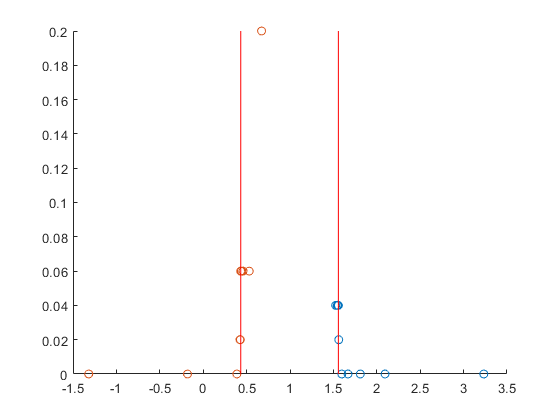

In [8]:
CI
[Q_UB, Q_LB]
figure(4)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off

### Use with `kstest()` for Kolmogorov-Smirnov test statistic

Getting a $p$-value only.

In [10]:
clear ri_ci
tic
[pval ] = ri_ci(D,{'y'},{'t'}, T0, R ...
    , 'Model', 'ks' ...
    , 'TestZero', true ... 
    , 'FindCI', false ...
    );
toc



TEST1 =

    0.1934

  Name       Size            Bytes  Class     Attributes

  TEST1      1x1                 8  double              

Elapsed time is 0.128419 seconds.



Finding the 95 percent confidence interval

In [11]:

clear ri_ci
tic
[pval ,~,~,~,CI,Q_UB,Q_LB] = ri_ci(D,{'y'},{'t'}, T0, R ...
    , 'Model', 'ks' ...
    , 'TestZero', true ... % don't bother with p-value for tau=0
    , 'FindCI', true ...
    );  % ,~,~,~,CI ,Q_UB, Q_LB 
toc


  File C:\Program Files\MATLAB\R2019a\toolbox\stats\stats\kstest2.m, line 111, in kstest2

  File D:\GitHub\RI_CI\m\ri_ci.m, line 305, in ri_estimates

  File D:\GitHub\RI_CI\m\ri_ci.m, line 139, in ri_ci
Sample vector X1 contains no data.



Error: -1

Illustrating the search process for the 95 percent confidence interval.

In [ ]:
[Q_UB, Q_LB]

figure(5)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off